In [3]:
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, f1_score
import joblib
import torch
import torch.nn as nn
from torchvision.transforms import Resize, ToTensor, Compose, Normalize, transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from os import listdir
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.layers import Reshape
from keras.layers import Input, Dense, concatenate
from keras.models import Model
from collections import defaultdict
from xgboost import XGBClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from torchvision.models import mobilenet_v3_large
from sklearn.metrics import precision_score, recall_score
import seaborn as sns

In [4]:
import torchvision.models as models

all_models = dir(models)
model_names = [model for model in all_models if callable(getattr(models, model))]
print("Available models in torchvision.models:")
#for name in model_names:
#    print(name)

Available models in torchvision.models:


In [5]:
data = pd.read_csv("/kaggle/input/brain-tumor-csv/Brain Tumor.csv")
data.head()

,Image,Class,Mean,Variance,Standard Deviation,Entropy,Skewness,Kurtosis,Contrast,Energy,ASM,Homogeneity,Dissimilarity,Correlation,Coarseness
0,Image1,0,6.535339,619.587845,24.891522,0.109059,4.276477,18.900575,98.613971,0.293314,0.086033,0.530941,4.473346,0.981939,7.458341e-155
1,Image2,0,8.749969,805.957634,28.389393,0.266538,3.718116,14.464618,63.858816,0.475051,0.225674,0.651352,3.220072,0.988834,7.458341e-155
2,Image3,1,7.341095,1143.808219,33.820234,0.001467,5.061750,26.479563,81.867206,0.031917,0.001019,0.268275,5.981800,0.978014,7.458341e-155
3,Image4,1,5.958145,959.711985,30.979219,0.001477,5.677977,33.428845,151.229741,0.032024,0.001026,0.243851,7.700919,0.964189,7.458341e-155
4,Image5,0,7.315231,729.540579,27.010009,0.146761,4.283221,19.079108,174.988756,0.343849,0.118232,0.501140,6.834689,0.972789,7.458341e-155


In [6]:
images = data.Image
classes = data.Class
image_label_dict = data.set_index('Image')['Class'].to_dict()
#print(image_label_dict)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [8]:
def preprocess_image(image_path):
  image = Image.open(image_path).convert('RGB')
  transform = transforms.Compose([
      transforms.Resize((224, 224)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  ])
  image = transform(image)
  image = image.unsqueeze(0)
  return image.to(device)
def extract_features(image, model):
  with torch.no_grad():
    feature = model(image).squeeze().cpu().numpy()
  return feature
def extract_features_from_image(image_path, model):
  image = preprocess_image(image_path)
  features = extract_features(image, model)
  return features
def preprocess_image_pca(image_path):
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image = transform(image)
    image = image.numpy().flatten()
    return image

**ResNet 18**

In [9]:
resnet18_model = resnet18(pretrained=True)
resnet18_model = nn.Sequential(*list(resnet18_model.children())[:-1])
resnet18_model = resnet18_model.to(device)
resnet18_model.eval()

dir_list = '/kaggle/input/reloaded-crop/Crop/'
X_resnet = []
X_pca_orig = []
Y = []
filename_list = []

for filename in tqdm(listdir(dir_list)):
  if filename.endswith('.jpg'):
    #print(filename)
    filename_list.append(filename)
    path = dir_list + filename
    label = image_label_dict.get(filename.split('.')[0], None)
    if label is not None:
      features = extract_features_from_image(path, resnet18_model)
      X_resnet.append(features)
      feature_pca = preprocess_image_pca(path)
      X_pca_orig.append(feature_pca)
      Y.append(label)
X_resnet = np.array(X_resnet)
X_pca_orig = np.array(X_pca_orig)
Y = np.array(Y)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 99.8MB/s]
100%|██████████| 3762/3762 [04:27<00:00, 14.09it/s]


In [10]:
print(X_resnet[0].shape)
print(X_pca_orig[0].shape)

(512,)
(150528,)


In [11]:
n_components = 0.95
pca_model = PCA(n_components=n_components, random_state=42)
X_pca = pca_model.fit_transform(X_pca_orig)
print(X_pca[0].shape)
X_pca = np.hstack((X_resnet, X_pca))

(378,)


In [12]:
print(X_pca[0].shape)

(890,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

C_values = [0.1, 0.5, 1, 2, 5, 10, 15, 20, 50]
gamma_values = ['scale', 'auto']

best_f1 = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        svm_model = SVC(kernel='rbf', C=C, gamma=gamma, random_state=42)
        svm_model.fit(X_train, y_train)
        y_val_pred = svm_model.predict(X_val)
        val_f1 = f1_score(y_val, y_val_pred)  
        if val_f1 > best_f1:
            best_f1 = val_f1
            best_params = {'C': C, 'gamma': gamma}

best_model = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], random_state=42)
best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(X_test)

print("Best Hyperparameters:", best_params)
print("Validation F1 Score:", best_f1)
print("Test F1 Score:", f1_score(y_test, y_test_pred))
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Classification Report:\n", classification_report(y_test, y_test_pred, digits=4))

Best Hyperparameters: {'C': 2, 'gamma': 'scale'}
Validation F1 Score: 0.9511677282377919
Test F1 Score: 0.9467213114754097
Accuracy: 0.9539823008849557
Precision: 0.9625
Recall: 0.9314516129032258
Classification Report:
               precision    recall  f1-score   support

           0     0.9477    0.9716    0.9595       317
           1     0.9625    0.9315    0.9467       248

    accuracy                         0.9540       565
   macro avg     0.9551    0.9515    0.9531       565
weighted avg     0.9542    0.9540    0.9539       565



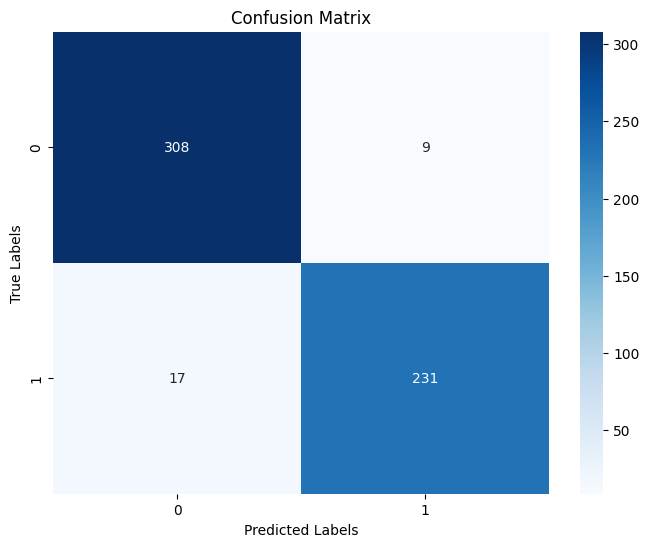

In [14]:
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(Y), yticklabels=np.unique(Y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [16]:
print(X_train.shape)

(2632, 890)


**ResNet18 + PCA + Model 1, 2, 3**

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1765, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
print(X_train.shape)

(2632, 890)


In [57]:
def create_cnn_model(input_shape, num_filters):
  model = Sequential()
  model = Sequential()
  model.add(Reshape((input_shape[1], 1), input_shape=input_shape[1:]))
  model.add(Conv1D(filters=num_filters, kernel_size=3, activation='relu', input_shape=(500, 1)))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=num_filters * 2, kernel_size=3, activation='relu'))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model1 = create_cnn_model(X_train.shape, 32)
model2 = create_cnn_model(X_train.shape, 64)
model3 = create_cnn_model(X_train.shape, 48)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('float32')
y_val = y_val.astype('float32')
y_test = y_test.astype('float32')

model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
model2.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
model3.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

loss, accuracy = model1.evaluate(X_test, y_test)
print(f'Accuracy1: {accuracy*100:.2f}%')

loss, accuracy = model2.evaluate(X_test, y_test)
print(f'Accuracy2: {accuracy*100:.2f}%')

loss, accuracy = model3.evaluate(X_test, y_test)
print(f'Accuracy3: {accuracy*100:.2f}%')

/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7040 - loss: 0.7988 - val_accuracy: 0.8761 - val_loss: 0.2903
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9053 - loss: 0.2381 - val_accuracy: 0.9292 - val_loss: 0.2079
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9546 - loss: 0.1383 - val_accuracy: 0.9062 - val_loss: 0.2146
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9589 - loss: 0.1070 - val_accuracy: 0.9345 - val_loss: 0.1767
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.9841 - loss: 0.0580 - val_accuracy: 0.9363 - val_loss: 0.1780
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.9923 - loss: 0.0385 - val_accuracy: 0.9451 - val_loss: 0.2188
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9967 - loss: 0.0178 - val_accuracy: 0.9221 - val_loss: 0.2209
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.9981 - loss: 0.0146 - val_accuracy: 0.9504 - v

In [58]:
y_pred1 = model1.predict(X_test)
y_pred2 = model2.predict(X_test)
y_pred3 = model3.predict(X_test)

thresholds = np.arange(0, 1.01, 0.01) 
best_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
  y_pred_classes = (y_pred1 >= threshold).astype(int)
  f1 = f1_score(y_test, y_pred_classes)
  if f1 > best_f1:
    best_f1 = f1
    best_threshold = threshold
print(f'F1-score1: {best_f1:.4f}')
y_pred1 = (y_pred1 > best_threshold).astype(int)

best_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
  y_pred_classes = (y_pred2 >= threshold).astype(int)
  f1 = f1_score(y_test, y_pred_classes)
  if f1 > best_f1:
    best_f1 = f1
    best_threshold = threshold
print(f'F1-score2: {best_f1:.4f}')
y_pred2 = (y_pred2 > best_threshold).astype(int)

best_threshold = 0.0
best_f1 = 0.0

for threshold in thresholds:
  y_pred_classes = (y_pred3 >= threshold).astype(int)
  f1 = f1_score(y_test, y_pred_classes)
  if f1 > best_f1:
    best_f1 = f1
    best_threshold = threshold
print(f'F1-score3: {best_f1:.4f}')
y_pred3 = (y_pred3 > best_threshold).astype(int)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
F1-score1: 0.9522
F1-score2: 0.9551
F1-score3: 0.9504


In [59]:
def print_metrics(y_test, y_pred, model_number):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Model {model_number} - Metrics:")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - Model {model_number}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

Model 1 - Metrics:
Accuracy: 95.93%
Precision: 0.9828
Recall: 0.9234
F1 Score: 0.9522

Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.99      0.96       317
         1.0       0.98      0.92      0.95       248

    accuracy                           0.96       565
   macro avg       0.96      0.96      0.96       565
weighted avg       0.96      0.96      0.96       565



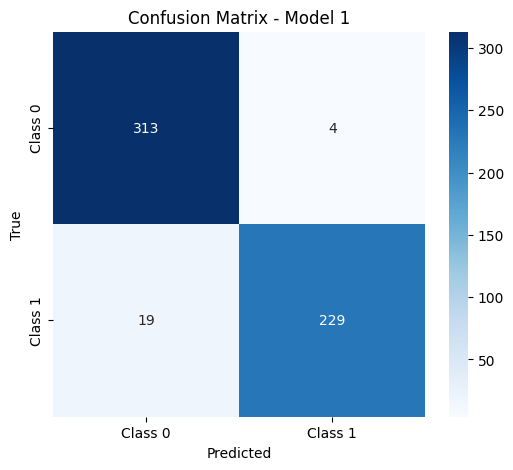

In [60]:
print_metrics(y_test, y_pred1, 1)

Model 2 - Metrics:
Accuracy: 96.11%
Precision: 0.9669
Recall: 0.9435
F1 Score: 0.9551

Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97       317
         1.0       0.97      0.94      0.96       248

    accuracy                           0.96       565
   macro avg       0.96      0.96      0.96       565
weighted avg       0.96      0.96      0.96       565



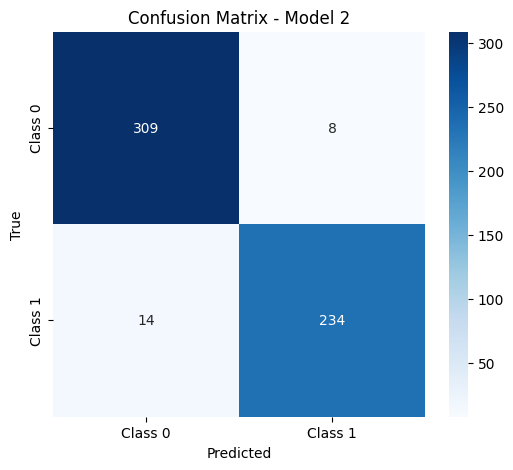

In [61]:
print_metrics(y_test, y_pred2, 2)

Model 3 - Metrics:
Accuracy: 95.75%
Precision: 0.9746
Recall: 0.9274
F1 Score: 0.9504

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96       317
         1.0       0.97      0.93      0.95       248

    accuracy                           0.96       565
   macro avg       0.96      0.95      0.96       565
weighted avg       0.96      0.96      0.96       565



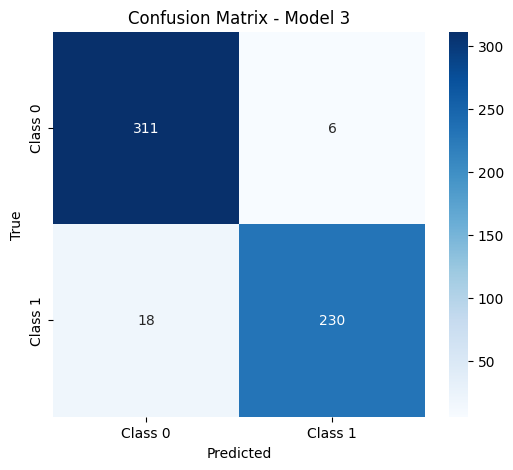

In [62]:
print_metrics(y_test, y_pred3, 3)

In [63]:
y_pred1_prob = model1.predict(X_train).flatten()  
y_pred2_prob = model2.predict(X_train).flatten()  
y_pred3_prob = model3.predict(X_train).flatten()  

y_pred_probs_train = np.column_stack((y_pred1_prob, y_pred2_prob, y_pred3_prob))

C_values = [0.1, 0.5, 1, 2, 5, 10, 15, 20, 50]
gamma_values = ['scale', 'auto']

best_f1 = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        ensemble_model_svm = SVC(kernel='rbf', C=C, gamma=gamma, probability=True, random_state=42)
        ensemble_model_svm.fit(y_pred_probs_train, y_train)

        y_pred1_prob_val = model1.predict(X_val).flatten()  
        y_pred2_prob_val = model2.predict(X_val).flatten()  
        y_pred3_prob_val = model3.predict(X_val).flatten()

        y_pred_probs_val = np.column_stack((y_pred1_prob_val, y_pred2_prob_val, y_pred3_prob_val))

        y_pred_ensemble_svm = ensemble_model_svm.predict(y_pred_probs_val)

        f1_ensemble_svm = f1_score(y_val, y_pred_ensemble_svm)

        if f1_ensemble_svm > best_f1:
            best_f1 = f1_ensemble_svm
            best_params = {'C': C, 'gamma': gamma}

print(f"Best Hyperparameters: {best_params}")
print(f"Best F1-score (Ensemble SVM on Validation): {best_f1:.4f}")

ensemble_model_svm = SVC(kernel='rbf', C=best_params['C'], gamma=best_params['gamma'], probability=True, random_state=42)
ensemble_model_svm.fit(y_pred_probs_train, y_train)

y_pred1_prob_test = model1.predict(X_test).flatten() 
y_pred2_prob_test = model2.predict(X_test).flatten()  
y_pred3_prob_test = model3.predict(X_test).flatten()

y_pred_probs_test = np.column_stack((y_pred1_prob_test, y_pred2_prob_test, y_pred3_prob_test))

y_pred_ensemble_svm = ensemble_model_svm.predict(y_pred_probs_test)

f1_ensemble_svm_test = f1_score(y_test, y_pred_ensemble_svm)
accuracy_ensemble_svm_test = accuracy_score(y_test, y_pred_ensemble_svm)
precision_ensemble_svm_test = precision_score(y_test, y_pred_ensemble_svm)
recall_ensemble_svm_test = recall_score(y_test, y_pred_ensemble_svm)

print(f'Ensemble F1-score (SVM on Test Set): {f1_ensemble_svm_test:.4f}')
print(f'Ensemble Accuracy (SVM on Test Set): {accuracy_ensemble_svm_test:.4f}')
print(f'Ensemble Precision (SVM on Test Set): {precision_ensemble_svm_test:.4f}')
print(f'Ensemble Recall (SVM on Test Set): {recall_ensemble_svm_test:.4f}')

83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
18/18 ━━━

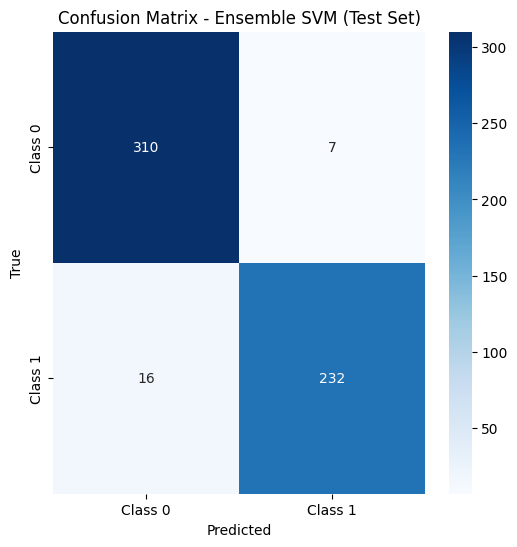

In [66]:
cm = confusion_matrix(y_test, y_pred_ensemble_svm)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Ensemble SVM (Test Set)')
plt.show()

In [68]:
import joblib
import torch

joblib.dump(model1, '/kaggle/working/model1.pkl')
joblib.dump(model2, '/kaggle/working/model2.pkl')
joblib.dump(model3, '/kaggle/working/model3.pkl')
joblib.dump(ensemble_model_svm, '/kaggle/working/ensemble_model_svm.pkl')
joblib.dump(pca_model, '/kaggle/working/pca_model.pkl')
joblib.dump(scaler, '/kaggle/working/scaler.pkl')
joblib.dump(best_model, '/kaggle/working/svm.pkl')

['/kaggle/working/svm.pkl']